In [2]:
device = 'cuda:0'

In [3]:
## from __future__ import print_function
from __future__ import division

import argparse
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
import copy
import math
import cv2
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from tqdm import tqdm
import torch.optim as optim
import torchvision
from torchvision import transforms, models
from torchvision.models import inception_v3, vgg11_bn
from torchvision.utils import make_grid
from torchvision.utils import save_image
import torch.nn.functional as F
cuda = True if torch.cuda.is_available() else False
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

import warnings
warnings.filterwarnings('ignore')
torch.manual_seed(0)

In [4]:
# PARAMETERS
model_name = 'vgg'
num_classes = 2
batch_size = 256
feature_extract = False
img_size = 96

In [5]:
# !wget https://download.pytorch.org/models/vgg11_bn-6002323d.pth --no-check-certificate

In [6]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
    else:
        for param in list(model.parameters())[:16]:
            param.requires_grad = False

In [7]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = vgg11_bn(pretrained=False)
        model_ft.load_state_dict(torch.load('pretrained_weights/vgg11_bn-6002323d.pth'))
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [8]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, header=0):
        self.annotations = pd.read_csv(csv_file, header=header)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = cv2.imread(img_path)
        image =  cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)

        return (image, y_label)
    



transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))])
    #transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])


In [9]:
# HEERLEN DATASETS

train_csv_file = 'HR_evaluate_train.csv'
val_csv_file = 'HR_evaluate_val.csv'
test_csv_file = 'HR_evaluate_test.csv'

dataset_path = '/data1/Heerlen_HR_2018/full/'

train_dataset = CustomDataset(csv_file='/data1/Itzel/csv_files/' + train_csv_file,
                         root_dir=dataset_path,
                         transform=transform,
                         header=0)
val_dataset = CustomDataset(csv_file='/data1/Itzel/csv_files/' + val_csv_file,
                         root_dir=dataset_path,
                         transform=transform,
                         header=0)

test_dataset = CustomDataset(csv_file='/data1/Itzel/csv_files/' + test_csv_file,
                         root_dir=dataset_path,
                         transform=transform,
                         header=0)

# GENERATED DATASET


gan_model_name = 'amodel3'
gan_csv_file = 'labels_5000_samples.csv'

gan_dataset_path = '/data1/Itzel/AGAN_results/' + gan_model_name + '/final_imgs5000/'
gan_csv_path = '/data1/Itzel/AGAN_results/' + gan_model_name + '/'+ gan_csv_file
gan_dataset = CustomDataset(csv_file=gan_csv_path,
                             root_dir=gan_dataset_path,
                             transform=transform,
                             header=0)



len(gan_dataset)

5000

#### Merge datasets

In [10]:
# # if we want to merge the train & test dataset
# train_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])
# len(train_dataset)

In [11]:
add_generation = True

In [12]:
if add_generation:
    train_gan_set, val_gan_set = torch.utils.data.random_split(gan_dataset, [round(0.8*len(gan_dataset)), round(0.2*len(gan_dataset))])
    
    train_set = torch.utils.data.ConcatDataset([train_dataset, train_gan_set])
    val_set = torch.utils.data.ConcatDataset([val_dataset, val_gan_set])
    
    print('Train set:', len(train_set))
    print('Val set:', len(val_set))
else:
    train_set = train_dataset
    val_set = val_dataset
    print('Train set:', len(train_set))
    print('Val set:', len(val_set))

Train set: 20692
Val set: 5769


In [13]:
dataloaders_dict = {'train': DataLoader(dataset=train_set,
                         batch_size=batch_size,
                         shuffle=True),
                    'val': DataLoader(dataset=val_set,
                         batch_size=batch_size,
                         shuffle=True)}

in model_ft.named_parameters() the weights and biases of the convlayer and batchnorm are given

In [14]:
# Send the model to GPU
model_ft = model_ft.to(device)
params_to_update = model_ft.parameters()

In [15]:
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 features.15.weight
	 features.15.bias
	 features.16.weight
	 features.16.bias
	 features.18.weight
	 features.18.bias
	 features.19.weight
	 features.19.bias
	 features.22.weight
	 features.22.bias
	 features.23.weight
	 features.23.bias
	 features.25.weight
	 features.25.bias
	 features.26.weight
	 features.26.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


### Model training

In [16]:
def compute_accuracy(classification, labels):
    counter = 0
    false_classified_indices = []
    for i in range(len(classification)):
        if np.array_equal(int(classification[i]), int(labels[i])):
            counter += 1
        else:
            false_classified_indices.append(i)
    acc = counter/len(classification)
    return acc, false_classified_indices

In [17]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            all_preds = []
            all_labels = []

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                all_labels.append(labels)
                all_preds.append(preds)
                
            all_labels_epoch = [int(item.cpu()) for sublist in all_labels for item in sublist]
            all_preds_epoch = [int(item.cpu()) for sublist in all_preds for item in sublist]
            
            # accuracy, _ = compute_accuracy(all_preds_epoch, all_labels_epoch)
            rec = recall_score(all_labels_epoch, all_preds_epoch)
            prec = precision_score(all_labels_epoch, all_preds_epoch)


            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            # print('{}: Self computed acc: {:.4f}'.format(phase, accuracy))
            print('{} Recall: {:.4f} Precision: {:.4f}'.format(phase, rec, prec))

            

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [18]:
num_epochs = 5

In [19]:
criterion = nn.CrossEntropyLoss()
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=='inception'))

Epoch 0/4
----------
train Loss: 0.3872 Acc: 0.8346
train Recall: 0.6395 Precision: 0.8530
val Loss: 0.2344 Acc: 0.9099
val Recall: 0.8252 Precision: 0.8976

Epoch 1/4
----------
train Loss: 0.2009 Acc: 0.9233
train Recall: 0.8473 Precision: 0.9281
val Loss: 0.1756 Acc: 0.9334
val Recall: 0.8573 Precision: 0.9388

Epoch 2/4
----------
train Loss: 0.1517 Acc: 0.9437
train Recall: 0.8895 Precision: 0.9470
val Loss: 0.1571 Acc: 0.9409
val Recall: 0.8516 Precision: 0.9683

Epoch 3/4
----------
train Loss: 0.1237 Acc: 0.9545
train Recall: 0.9098 Precision: 0.9587
val Loss: 0.1386 Acc: 0.9471
val Recall: 0.8785 Precision: 0.9604

Epoch 4/4
----------
train Loss: 0.1023 Acc: 0.9624
train Recall: 0.9253 Precision: 0.9662
val Loss: 0.1287 Acc: 0.9523
val Recall: 0.8940 Precision: 0.9611

Training complete in 7m 42s
Best val Acc: 0.952331


In [20]:
# torch.save(model_ft, '/data1/Itzel/model1')

### Test set

In [21]:
# model_base = torch.load('/data1/Itzel/model1')

In [22]:
test_csv_file = 'HR_evaluate_test.csv'
test_dataset = CustomDataset(csv_file='/data1/Itzel/csv_files/' + test_csv_file,
                         root_dir=dataset_path,
                         transform=transform,
                         header=0)


csv_file_ZL = 'ZL_cleaned_10000.csv'
ZL_path = '/data1/ZL_2018_HR/full/'
ZL_dataset = CustomDataset(csv_file= '/data1/Itzel/csv_files/' + csv_file_ZL,
                                      root_dir=ZL_path,
                                      transform=transform)
print('ZL test set:', len(ZL_dataset))
print('HR test set:', len(test_dataset))

ZL test set: 10000
HR test set: 2386


In [23]:
test_name = 'ZL'

In [24]:
if test_name == 'ZL':
    testloader = DataLoader(dataset=ZL_dataset,
                         batch_size=batch_size,
                         shuffle=True)
else:
    testloader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=True)

In [25]:
model_ft = model_ft.eval()

In [26]:
all_classif = []
all_labels = []
# with torch.no_grad():
for images, labels in testloader:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model_ft(images)
    values, test_classif = torch.max(outputs.data, 1)
    all_classif.append(test_classif)
    all_labels.append(labels)

In [27]:
all_classif_flat = [int(item.cpu()) for sublist in all_classif for item in sublist]

In [28]:
all_labels_flat = [int(item.cpu()) for sublist in all_labels for item in sublist]

In [29]:
len(all_classif_flat)

10000

In [30]:
len(all_labels_flat)

10000

In [31]:
accuracy, false_classified_indices = compute_accuracy(all_classif_flat, all_labels_flat)

In [32]:
len(false_classified_indices)

1259

In [33]:
accuracy

0.8741

- recall: tp / (tp + fn)
- precision: tp / (tp + fp)

In [34]:
print('Recall:', recall_score(all_labels_flat, all_classif_flat))
print('Precision:', precision_score(all_labels_flat, all_classif_flat))

Recall: 0.59899389148401
Precision: 0.9209944751381215


In [35]:
conf = confusion_matrix(all_labels_flat,all_classif_flat)

In [36]:
def plot_conf_matrix(conf_matrix):
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                 display_labels=['negative', 
                                                 'positive'])
    disp.plot(values_format='d')
    plt.rcParams['figure.figsize'] = 5,5
    plt.title('Confusion matrix')

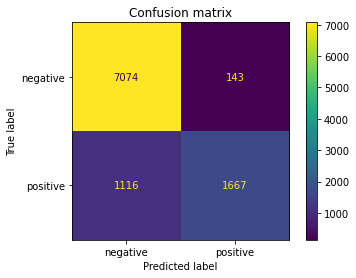

In [37]:
plot_conf_matrix(conf)